Created by Sanish Bhochhibhoya (04/23/2025)

### Data-Driven FWI: Prediction on Testing Dataset

Notebook to perform a prediction on the simulated testing dataset using Vantassel and Bhochhibhoya (2025) model.

Requirements:
1) Waveforms must be in .npy format before feeding them to the AI model. The waveform data should have a shape of 24 × 1000, representing 24 receivers and 1000 milliseconds of recorded data (fs=1000Hz). The preprocessing procedure outlined by Vantassel and Bhochhibhoya (2025), which includes truncating the waveforms to 500 milliseconds and excluding the two central receivers, will be applied automatically later in its in-built preprocessing codes.
2) For the real-field dataset, it is recommended to apply the correction procedure proposed by Forbriger et al. (2014).
3) Provided generated_data (simulated testing data) is in HDF5 format, which contains simulated waveform-profile pairs of 500 testing datasets (out of 10000).

How to run these notebooks:
1) Install all the requirements in requirements.txt
2) Have folders - data and fwiprepostai, and notebooks in the same directory.

In [1]:
def get_data_from_hdf5(to_file, index):
    with h5py.File(to_file, 'r') as f:
        waveform_data = f['data_after_utils']['waveforms_r30'][()]
        waveform_data = waveform_data[index]
        images_vs_data = f['data_after_utils']['vs'][()][index]
        images_vs_data = truncate_read_files_vs(images_vs_data[None, ...], 60,0.25,5,55,25,0.25,0,20)
        images_vs_data = pooling_multi(images_vs_data, (4,4), 'mean')[0]
    return waveform_data, images_vs_data

def pooling_multi(array, kernel_size_2d=(2,2), method='max', dtype='float32'):
    if method==None:
        return array.astype(dtype)
    assert len(kernel_size_2d) == 2, f"kernel_size_2d should be 2-dimensional tuple. Eg.(2,2), provided dim={len(kernel_size_2d)}."
    assert method=='max' or method=='mean', f"method allowed is 'max' for maxpooling, and 'mean' for meanpooling."
    block_size = (1, kernel_size_2d[0], kernel_size_2d[1])
    if method=='mean':
        array_reduced=block_reduce(array, block_size=block_size, func=np.nanmean, cval=np.nan, func_kwargs={'dtype': np.float64})
    elif method == 'max':
        array_reduced=block_reduce(array, block_size=block_size, func=np.nanmax, cval=np.nan)
    return array_reduced.astype(dtype)
        
def truncate_read_files_vs(vs, y_lim, del_y, trunc_start_y, trunc_end_y, z_lim, del_z, trunc_start_z, trunc_end_z):
    trunc_y_index = get_trunc_y_or_z_index(y_lim, del_y, trunc_start_y, trunc_end_y)
    trunc_z_index = get_trunc_y_or_z_index(z_lim, del_z, trunc_start_z, trunc_end_z)
    return vs[:,:,trunc_y_index][:,trunc_z_index,:]

def get_trunc_y_or_z_index(y_or_z_lim, del_yz, trunc_start_yz, trunc_end_yz):
    curr_yz_index = np.arange(0, y_or_z_lim+del_yz/2, del_yz) 
    condition = (curr_yz_index >= trunc_start_yz) & (curr_yz_index < trunc_end_yz)  
    indices = np.argwhere(condition).flatten()
    return indices

In [2]:
###### import pandas as pd
import numpy as np
import os, pprint, h5py
import matplotlib.pyplot as plt
import fwiprepostai.data_analysis as data_analysis
import fwiprepostai.data_driven_fwi_models as fwi_models
from skimage.measure import block_reduce

to_waveform_model_wt = r'data\model_weights\VantasselAndBhochhibhoya2025.weights.h5'
to_hdf5_file = r'data\waveforms\generated_data\samples_500_116.hdf5'
raw_waveform, vs_act = get_data_from_hdf5(to_hdf5_file, 87)  #269, 87, 252 are used in Fig4 of Vantassel and Bhochhibhoya 2025 paper.

print(vs_act.shape)

(20, 50)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


<Axes: title={'center': 'MAPE = 34%'}>

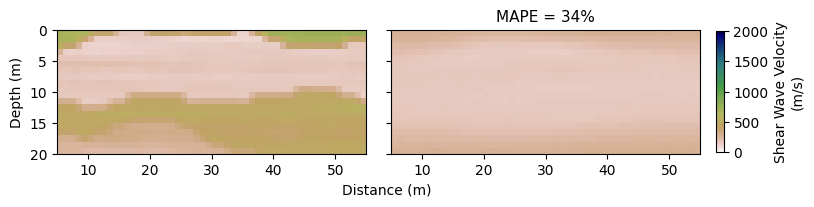

In [3]:
model = fwi_models.VantasselAndBhochhibhoya2025(to_waveform_model_wt)
vs_pred = data_analysis.get_prediction(model, raw_waveform, 0)[1]
mape = data_analysis.get_accuracy(vs_act, vs_pred, 'mape')
data_analysis.plot_prediction(vs_act, vs_pred, 'mape', vmin=0, vmax=2000, extent = [5,55,20,0])